# Figure Notebook

In [4]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [5]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [6]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX','PRECT']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

# Years when GLENS anom = half eventual cooling found using offline calculation with this function call: closest_years_to_frac_GLENS(0.5)
t_index_feedback_half = np.where((years_feedback > 2043) & (years_feedback < 2064))[0]
t_index_control_half = np.where((years_control > 2043) & (years_control < 2064))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [7]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_frac' - Land fraction
'land_mask' - binary land mask where land fraction > 50%
'land_noice_frac' land fraction without Greenland or Antarctica
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_frac' - Land fraction\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_frac' land fraction without Greenland or Antarctica\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\n    \nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [11]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

/n/home03/pjirvine/.conda/envs/climate_odyssey/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7058: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/n/home03/pjirvine/.conda/envs/climate_odyssey/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


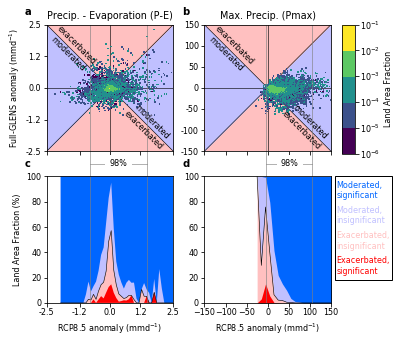

In [25]:
# %load figure_sections/fig_2.py

"""
GFDL 2D histogram
"""

from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec
import matplotlib.patches as patches

"""
Define function to get data in format for plot
"""

def sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f'):
    
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)

    axis.set_yticks(np.linspace(ylims[0],ylims[1],xnum_steps))
    axis.set_xticks(np.linspace(ylims[0],ylims[1],ynum_steps))

    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))

def add_lines(axis):
    axis.axhline(0, color='k',zorder=0, lw=0.6)
    axis.axvline(0, color='k',zorder=0, lw=0.6)
    axis.plot(xlims,xlims, color='k',zorder=0, lw=0.6)
    axis.plot([xlims[0],-1.*xlims[0]],[-1.*xlims[0],xlims[0]], color='k',zorder=0, lw=0.6)
    
def bw_off_plot_func(CO2_anom,values,mask,weight):
    
    # Calculate fraction of CO2 anom distribution across values with weighted mask
    bwd = np.array(fraction_distribution(CO2_anom[mask], values, sample_weight=weight[mask]))
    # Return 100* fraction of points at each interval that are masked
    return 100 * bwd / (total * np.sum(weight) / np.sum(weight[mask]))

def plot_angled_labels(xlims):
    #plots angled labels to indicate moderated / exacerbated
    
    start_loc = (0.8/1.5)*xlims[1]
    top_left = [-1.*start_loc,start_loc]
    bottom_right = [start_loc,-1.*start_loc]
    shift = (0.2/1.5)*xlims[1]
    plt.text(top_left[0]-shift,top_left[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(top_left[0],top_left[1]+shift,'exacerbated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0]+shift,bottom_right[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0],bottom_right[1]-shift,'exacerbated',ha='center',va='center',rotation=-45)

def plot_range_top(ylims, q_range=[0.01,0.99]):
    # plots the 1-99% range of data vertically
    
    range_1_99 = weighted_quantile(CO2_anom.flatten(), q_range, sample_weight=weight)
    
    plt.plot([range_1_99[0],range_1_99[0]],[ylims[1],1.4*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    plt.plot([range_1_99[1],range_1_99[1]],[ylims[1],1.4*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    
    plt.plot([range_1_99[0],range_1_99[1]],[1.2*ylims[0],1.2*ylims[0]],color='0.5', lw=0.6, clip_on=False)
    plt.text( (range_1_99[0]+range_1_99[1])/2.0,1.2*ylims[0],'98%',va='center',ha='center',
             clip_on=False, color='black', bbox=dict(facecolor='white', edgecolor='white'))
    
def plot_range_bottom(q_range=[0.01,0.99]):
    range_1_99 = weighted_quantile(CO2_anom.flatten(), q_range, sample_weight=weight)
    plt.axvline(x=range_1_99[0],color='0.5', lw=0.6)
    plt.axvline(x=range_1_99[1],color='0.5', lw=0.6)
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
"""
Cases to plot
"""

out_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/figures_temp/'

out_name = 'fig_2_Full-GLENS'
y_label = 'Full-GLENS anomaly (mmd$^{-1}$)'

cases = ['Full-GLENS','RCP8.5','Baseline']
var_1 = 'P-E'
var_2 = 'PRECTMX'

flipped = False

# for flipped reverse order of baseline and RCP8.5 and invert plots
if flipped:
    cases_new = [cases[0],cases[2],cases[1]]
    cases = cases_new

"""
settings
"""

var_1_xlims = [-2.5,2.5]
var_1_xnum_steps = 5
var_1_bottom_step = 0.1

var_1_ticks = [-2.5,-1.2,0,1.2,2.5]
var_1_ticklabels = ['-2.5','-1.2','0.0','1.2','2.5']

var_1_aspect = 5./100. # set so bottom panel has same aspect ratio as top

var_2_xlims = [-150,150]
var_2_xnum_steps = 7
var_2_bottom_step = 10.

var_2_ticks = [-150,-100,-50,0,50,100,150]
var_2_ticklabels = ['-150','-100','-50','0','50','100','150']

var_2_aspect = 300./100. # set so bottom panel has same aspect ratio as top

frac_100 = False
background = True
line_1_99_top = True
line_1_99_bottom = True
angled_labels = True

"""
Get mask
"""

weight = all_masks['land_noice_area'].flatten()

"""
Common settings
"""

bounds = [1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
labels = ['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$']

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# g_cmap = plt.cm.gist_gray
# g_norm = mpl.colors.BoundaryNorm(bounds, g_cmap.N)

nbins = 200

"""
Create figure
"""

fig = plt.figure(figsize=cm2inch(15,13))
plt.rcParams.update({'font.size': 8})

"""
Start TOP
"""

"""
p-e no filter
"""

axis = fig.add_subplot(221)
ax_pe_top = axis

var = var_1

plt.title('Precip. - Evaporation (P-E)')

plt.axis('scaled')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')
if flipped:
    CO2_anom = -1. * CO2_anom
    sg_anom  = -1. * sg_anom

# Set axes and add lines

xlims = var_1_xlims
ylims = xlims
xnum_steps = var_1_xnum_steps
ynum_steps = xnum_steps

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom.flatten(), sg_anom.flatten(), bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])
# img = ax_pe.hist2d(CO2_anom[certain], SRM_anom[certain], bins=100, range = [xlims,ylims], weights=weight[certain], norm=norm, cmap=cmap, cmin=1.e-12)

if line_1_99_top:
    plot_range_top(ylims)

if angled_labels:
    plot_angled_labels(xlims)
    
plt.ylabel(y_label)

if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)

plt.text(1.35*xlims[0], 1.15*xlims[1], "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')
    
"""
precip 5 max
"""

axis = fig.add_subplot(222)
ax_p5_top = axis

var = var_2

plt.title('Max. Precip. (Pmax)')

plt.axis('scaled')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')
if flipped:
    CO2_anom = -1. * CO2_anom
    sg_anom  = -1. * sg_anom

# Set axes and add lines

xlims = var_2_xlims
ylims = xlims
xnum_steps = var_2_xnum_steps
ynum_steps = xnum_steps

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.0f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom.flatten(), sg_anom.flatten(), bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

if line_1_99_top:
    plot_range_top(ylims)

if angled_labels:
    plot_angled_labels(xlims)
    
if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)
    
plt.text(1.35*xlims[0], 1.15*xlims[1], "b", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')
    
"""
Create BOTTOM figure
"""

"""
p-e no filter
"""

axis = fig.add_subplot(223)
ax_pe_mid = axis

# plt.title('Precip -Evap (mmd$^{-1}$)')

var = var_1

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')

xmin, xmax = var_1_xlims
step = var_1_bottom_step

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom.flatten(), values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    plot_range_bottom()

plt.ylabel('Land Area Fraction (%)')
plt.xlabel('RCP8.5 anomaly (mmd$^{-1}$)')

plt.text(1.35*var_1_xlims[0], 1.075*100, "c", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
precip 5 max
"""

axis = fig.add_subplot(224)
ax_p5_mid = axis

var = var_2

# plt.title('5 Day Max Precip (mmd$^{-1}$)')

sg_anom, CO2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, cases[0], cases[1], cases[2], var, weight, anom_type='standard')

xmin, xmax = var_2_xlims
step = var_2_bottom_step

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom.flatten(), values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom.flatten(),values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    plot_range_bottom()

plt.xlabel('RCP8.5 anomaly (mmd$^{-1}$)')

plt.text(1.35*var_2_xlims[0], 1.075*100, "d", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
add legend
"""

left_begin = 160
left_in = 3
bot_begin = 18

# Create a Rectangle patch
rect = patches.Rectangle((left_begin,bot_begin),135,82,linewidth=1,edgecolor='k',facecolor='white',clip_on=False)

# Add the patch to the Axes
ax_p5_mid.add_patch(rect)

plt.text(left_begin+left_in, 83, "Moderated,\nsignificant",clip_on=False, color=blue, 
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 63, "Moderated,\ninsignificant",clip_on=False, color=l_blue,
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 43, "Exacerbated,\ninsignificant",clip_on=False, color=l_red,
         va="baseline", ha="left", multialignment="left")
plt.text(left_begin+left_in, 23, "Exacerbated,\nsignificant",clip_on=False, color=red,
         va="baseline", ha="left", multialignment="left")

"""
Finish up figures
"""

fig.subplots_adjust(right=0.85)
# add_axes defines new area with: X_start, Y_start, width, height
cax = fig.add_axes([0.85,0.53,0.03,0.35])
cbar = fig.colorbar(img[3], cax=cax, ticks=bounds, format='%0.0e')
cbar.set_ticklabels(labels)
cbar.set_label('Land Area Fraction')

# reduce space between ticks and tick labels
ax_pe_top.tick_params(pad=2)
ax_p5_top.tick_params(pad=2)
ax_pe_mid.tick_params(pad=2)
ax_p5_mid.tick_params(pad=2)
cax.tick_params(pad=2)

# set PE ticks
ax_pe_top.get_xaxis().set_ticks(var_1_ticks)
ax_pe_mid.get_xaxis().set_ticks(var_1_ticks)
ax_pe_top.get_xaxis().set_ticklabels(var_1_ticklabels)
ax_pe_mid.get_xaxis().set_ticklabels(var_1_ticklabels)

ax_p5_top.get_xaxis().set_ticks(var_2_ticks)
ax_p5_top.get_yaxis().set_ticks(var_2_ticks)
ax_p5_mid.get_xaxis().set_ticks(var_2_ticks)

# hide top x axis tick labels
ax_pe_top.get_xaxis().set_ticklabels([])
ax_p5_top.get_xaxis().set_ticklabels([])

ax_pe_mid.set_aspect(var_1_aspect) # set so bottom panel has same aspect ratio as top
ax_p5_mid.set_aspect(var_2_aspect)

"""
colorbar articles:
https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.colorbar
https://matplotlib.org/users/colormapnorms.html
https://matplotlib.org/tutorials/colors/colorbar_only.html
https://stackoverflow.com/questions/21952100/setting-the-limits-on-a-colorbar-in-matplotlib
"""

fig.subplots_adjust(left=0.15, right=0.83, wspace = 0.2, hspace=0.2)

plt.savefig(out_dir+out_name+'.png', format='png', dpi=600)
plt.savefig(out_dir+out_name+'.eps', format='eps', dpi=600)
    
plt.show()


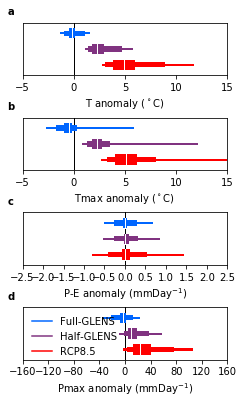

In [13]:
# %load figure_sections/fig_1.py

#customize ticks
import matplotlib.ticker as ticker

"""
Figure settings
"""

out_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/figures_temp/'

weight = 'land_noice_area'
out_filename = 'fig1'

# # For population-weighted version
# weight = 'pop'
# out_filename = 'fig1_pop'

quantiles = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
"""

def plot_data(var, case_a, case_b, weight_name, quantiles = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]):
    # returns weighted quantiles of the anomaly for plotting
    # take anomaly of means [0] element
    anom = all_data[(var, case_a)][0] - all_data[(var, case_b)][0]
    anom_flat = anom.flatten()
    weight_flat = all_masks[weight_name].flatten()
    # return weighted quantiles of distribution
    return weighted_quantile(anom_flat, quantiles, sample_weight=weight_flat)

def box_rectangles(axis, quantiles, y_loc, thick, color):

    thin = thick*0.5
    thinner = thick*0.2

    # create a rectangle
    patches = [
        # 1-99% range
        mpatches.Rectangle((quantiles[0],y_loc-0.5*thinner), quantiles[-1] - quantiles[0], thinner, facecolor=color, linewidth=0), ### Background
        # 5-95% range
        mpatches.Rectangle((quantiles[1],y_loc-0.5*thin), quantiles[-2] - quantiles[1], thin, facecolor=color, linewidth=0), ### Background
        # 25-75% range
        mpatches.Rectangle((quantiles[2],y_loc-0.5*thick), quantiles[-3] - quantiles[2], thick, facecolor=color, linewidth=0), ### Background
    ]
    for p in patches:
        axis.add_patch(p)

    axis.plot([quantiles[3],quantiles[3]],[y_loc-0.5*thick,y_loc+0.5*thick],'w',linewidth=1)
#end def

def boxplot_3(axis,bottom,mid,top,labels=False):
    """
    New GLENS style
    """
    
    # set y locations for bars
    y_bottom, y_mid, y_top = 0.2, 0.5, 0.8

    # set basic thickness
    thick = 0.2
    
    axis.set_ylim(0,1)
    axis.yaxis.set_major_locator(ticker.NullLocator())
    
    axis.plot([0,0],[0,1],'k',linewidth=1,zorder=0)
    
    # plot the shapes:
    box_rectangles(axis, bottom, y_bottom, thick, red)
    box_rectangles(axis, mid, y_mid, thick, purple)
    box_rectangles(axis, top, y_top, thick, blue)
#end def

"""
##################################
#
FIGURE 1 GLENS
#
##################################
"""

fig = plt.figure(figsize=cm2inch(8.5,14))

def fig1_land(ax, var, mask):
    # get and then plot data
    RCP85_land = plot_data(var, 'RCP8.5', 'Baseline', weight)
    HALF_GLENS_land = plot_data(var, 'Half-GLENS', 'Baseline', weight)
    FULL_GLENS_land = plot_data(var, 'Full-GLENS', 'Baseline', weight)
    
    boxplot_3(ax, RCP85_land, HALF_GLENS_land, FULL_GLENS_land)

"""
TREFHT plot
"""
ax1 = fig.add_subplot(411)
ax=ax1

# plot data!
var = 'TREFHT'
xlims=[-5,15]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = '$^\circ$C'
plt.xlabel('T anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.3*xlims[0], 1.15, "a", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
TREFHTMX plot
"""
ax2 = fig.add_subplot(412)
ax=ax2

# plot data!
var = 'TREFHTMX'
xlims=[-5,15]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = '$^\circ$C'
plt.xlabel('Tmax anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.3*xlims[0], 1.15, "b", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
P-E plot
"""
ax3 = fig.add_subplot(413)
ax=ax3

# plot data!
var = 'P-E'
xlims = [-2.5,2.5]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = 'mmDay$^{-1}$'
plt.xlabel('P-E anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.15*xlims[0], 1.15, "c", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
PRECTMX plot
"""
ax4 = fig.add_subplot(414)
ax=ax4

# plot data!
var = 'PRECTMX'
xlims = [-160,160]
fig1_land(ax, var, weight)
    
# set axes labels and title
unit = 'mmDay$^{-1}$'
plt.xlabel('Pmax anomaly ({unit})'.format(unit=unit))
plt.xlim(xlims[0],xlims[1])

plt.text(1.15*xlims[0], 1.15, "d", clip_on=False, va="baseline", ha="left", fontsize=10, fontweight='bold')

"""
Plot legend
"""
# use empty plots
plt.plot(0,0, color=blue, label='Full-GLENS')
plt.plot(0,0, color=purple, label='Half-GLENS')
plt.plot(0,0, color=red, label='RCP8.5')

plt.legend(frameon=False)

"""
Figure finalizing
"""

ax3.get_xaxis().set_ticks([-2.5,-2,-1.5,-1,-0.5,0,0.5,1.0,1.5,2.0,2.5])
ax4.get_xaxis().set_ticks([-160,-120,-80,-40,0,40,80,120,160])

plt.subplots_adjust(top=0.95, bottom=0.1, left=0.10, right=0.95, hspace=0.8,
                    wspace=0.35)

plt.savefig(out_dir+out_filename+'.png', format='png', dpi=480)
plt.savefig(out_dir+out_filename+'.eps', format='eps', dpi=480)

plt.show()


# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [ ]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [ ]:
nc_data.shape

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

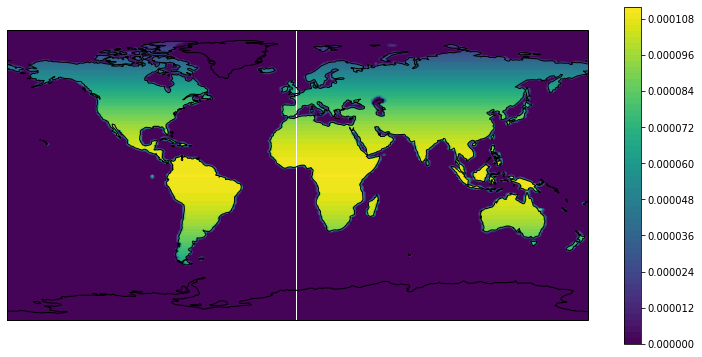

masked_array(
  data=[[-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0],
        [-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0],
        [-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0],
        [-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0],
        [-0.0, -0.0, -0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [23]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()
mask = all_masks['land_noice_area']#.transpose()

data = mask
# data = (all_data[('TREFHT','RCP8.5')][0] - all_data[('TREFHT','Baseline')][0])
# data = all_data[('P-E','Baseline')][0] * (all_data[('P-E','Baseline')][0] < 0) * (all_data[('P-E','Baseline')][0] > -0.5) * mask
# data = all_data[('P-E','Full-GLENS')][0] * (all_data[('P-E','Full-GLENS')][0] < 0) * (all_data[('P-E','Full-GLENS')][0] > -1.0) * mask
# data = all_data[('P-E','RCP8.5')][0] * (all_data[('P-E','RCP8.5')][0] < 0) * (all_data[('P-E','RCP8.5')][0] > -1.0) * mask
# data = np.transpose(all_masks['land_frac'])

fig = plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

CS = plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

fig.colorbar(CS) #cm.ScalarMappable(),ax=ax)

plt.show()

data

In [ ]:
plt.imshow(all_data[('P-E','RCP8.5')][0])